In [51]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [53]:
import pandas as pd
import seaborn as sns

from river import compose
from river import preprocessing
from river import ensemble
from sklearn.model_selection import train_test_split

from source.config import *
from source.utils.analysis_helper import load_groups_of_interest
from source.stability.incremental_stability_analyzer import IncrementalStabilityAnalyzer
from source.stability.stability_fairness_analyzer import StabilityFairnessAnalyzer
from source.utils.incremental_model_utils import train_incremental_model
from source.data_loaders.folktables_dataset_from_pd import FolktablesDatasetFromPandas

In [54]:
sns.set(rc={'figure.figsize':(15, 5)})
dataset_name = 'folktables'
state = 'LA'
dataset_config = DATASETS_CONFIG[dataset_name]
TARGET_COLUMN = dataset_config['target_column']

In [55]:
# Creating a data frame
df = pd.read_csv(f"../../datasets/folktables-{state}-2018.csv", delimiter=',')
df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,29,18,5,16,2,0,1,1,4,2,1,2,2,2,1,1,0
1,17,13,5,16,2,0,1,1,4,1,1,2,2,2,1,2,0
2,37,13,5,16,2,0,1,1,4,1,1,2,2,2,1,1,0
3,86,12,2,16,1,0,1,1,4,1,1,2,1,2,2,2,0
4,22,19,5,17,2,0,1,1,4,1,1,2,2,2,2,1,0


In [56]:
df.shape

(43588, 17)

In [57]:
df.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR'],
      dtype='object')

In [58]:
df['ESR'].value_counts()

0    25363
1    18225
Name: ESR, dtype: int64

In [59]:
dataset_size = df.shape[0]
test_size = int(TEST_FRACTION * dataset_size)
validation_size = test_size

train_cv_df, test_df = train_test_split(df, test_size=test_size, random_state=SEED)
train_df, cv_df = train_test_split(train_cv_df, test_size=validation_size, random_state=SEED)
print("train_df shape: ", train_df.shape)
print("cv_df shape: ", cv_df.shape)
print("test_df shape: ", test_df.shape)

train_df shape:  (26154, 17)
cv_df shape:  (8717, 17)
test_df shape:  (8717, 17)


In [60]:
train_dataset = FolktablesDatasetFromPandas(pd_dataset=train_df)

In [61]:
numerical_features = dataset_config['numerical_features']
categorical_features = [feature for feature in df.columns if feature not in numerical_features + [TARGET_COLUMN]]

categorical_features

['MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

### Apply data transformations

In [62]:
def get_transform_pipeline(categorical_features, numerical_features):
    transform_pipeline = compose.Select(categorical_features[0])
    for feature in categorical_features[1:]:
        transform_pipeline += compose.Select(feature)
    transform_pipeline |= preprocessing.OneHotEncoder()

    for feature in numerical_features:
        transform_pipeline += compose.Select(feature)
    transform_pipeline |= preprocessing.MinMaxScaler()

    return transform_pipeline

In [63]:
transform_pipeline = get_transform_pipeline(categorical_features, numerical_features)

for idx, (x, y) in enumerate(train_dataset):
    print(f'Initial features: {x}\n')
    x = transform_pipeline.transform_one(x)
    print(f'Transformed features: {x}\n\n')
    if idx + 1 == 10:
        break

Initial features: {'AGEP': 93, 'SCHL': 19, 'MAR': '3', 'RELP': '0', 'DIS': '1', 'ESP': '0', 'CIT': '1', 'MIG': '1', 'MIL': '4', 'ANC': '4', 'NATIVITY': '1', 'DEAR': '2', 'DEYE': '1', 'DREM': '2', 'SEX': '2', 'RAC1P': '1'}

Transformed features: {'SCHL': 0.0, 'AGEP': 0.0, 'RAC1P_1': 0.0, 'SEX_2': 0.0, 'DREM_2': 0.0, 'DEYE_1': 0.0, 'DEAR_2': 0.0, 'NATIVITY_1': 0.0, 'ANC_4': 0.0, 'MIL_4': 0.0, 'MIG_1': 0.0, 'CIT_1': 0.0, 'ESP_0': 0.0, 'DIS_1': 0.0, 'RELP_0': 0.0, 'MAR_3': 0.0}


Initial features: {'AGEP': 58, 'SCHL': 23, 'MAR': '3', 'RELP': '0', 'DIS': '2', 'ESP': '0', 'CIT': '1', 'MIG': '1', 'MIL': '4', 'ANC': '2', 'NATIVITY': '1', 'DEAR': '2', 'DEYE': '2', 'DREM': '2', 'SEX': '1', 'RAC1P': '1'}

Transformed features: {'SCHL': 1.0, 'AGEP': 0.0, 'RAC1P_1': 0.0, 'SEX_2': 0.0, 'SEX_1': 0.0, 'DREM_2': 0.0, 'DEYE_2': 0.0, 'DEYE_1': 0.0, 'DEAR_2': 0.0, 'NATIVITY_1': 0.0, 'ANC_2': 0.0, 'ANC_4': 0.0, 'MIL_4': 0.0, 'MIG_1': 0.0, 'CIT_1': 0.0, 'ESP_0': 0.0, 'DIS_2': 0.0, 'DIS_1': 0.0, 'RELP_0': 0.

### Analyze stability of Adaptive Random Forest classifier

In [64]:
def get_base_model():
    return ensemble.AdaptiveRandomForestClassifier(n_models=10, seed=SEED, split_criterion='gini'), 'Adaptive Random Forest'

In [65]:
base_model, base_model_name = get_base_model()

# Conduct model training
base_model = train_incremental_model(base_model, train_dataset, train_df.shape[0])

2022-11-22 14:43:44 incremental_model_utils.py INFO    : Iteration 1000/26154 -- Accuracy: 75.08%; WeightedF1: 74.89%
2022-11-22 14:43:45 incremental_model_utils.py INFO    : Iteration 2000/26154 -- Accuracy: 77.29%; WeightedF1: 77.28%
2022-11-22 14:43:47 incremental_model_utils.py INFO    : Iteration 3000/26154 -- Accuracy: 77.83%; WeightedF1: 77.90%
2022-11-22 14:43:49 incremental_model_utils.py INFO    : Iteration 4000/26154 -- Accuracy: 78.37%; WeightedF1: 78.46%
2022-11-22 14:43:51 incremental_model_utils.py INFO    : Iteration 5000/26154 -- Accuracy: 78.82%; WeightedF1: 78.89%
2022-11-22 14:43:53 incremental_model_utils.py INFO    : Iteration 6000/26154 -- Accuracy: 78.73%; WeightedF1: 78.82%
2022-11-22 14:43:55 incremental_model_utils.py INFO    : Iteration 7000/26154 -- Accuracy: 78.93%; WeightedF1: 79.02%
2022-11-22 14:43:56 incremental_model_utils.py INFO    : Iteration 8000/26154 -- Accuracy: 79.07%; WeightedF1: 79.16%
2022-11-22 14:43:58 incremental_model_utils.py INFO    :



Metrics after incremental model training:
Accuracy: 80.13%
WeightedF1: 80.21%


In [66]:
X_test_df = test_df.drop([TARGET_COLUMN], axis=1)
test_groups = load_groups_of_interest(group_info=TEST_GROUPS_CONFIG['folktables'], X_test_df=X_test_df)
stability_analyzer = IncrementalStabilityAnalyzer(base_model,
                                                  base_model_name=base_model_name,
                                                  train_pd_dataset=cv_df,
                                                  test_pd_dataset=test_df,
                                                  test_y_true=test_df[TARGET_COLUMN],
                                                  dataset_reader=FolktablesDatasetFromPandas,
                                                  dataset_name=dataset_name + '_LA',
                                                  n_estimators=200)

stability_fairness_analyzer = StabilityFairnessAnalyzer(stability_analyzer, test_groups)

2022-11-22 14:50:42 base_stability_analyzer.py INFO    : Start testing of classifier 1 / 200
2022-11-22 14:50:52 base_stability_analyzer.py INFO    : Classifier 1 / 200 was tested
2022-11-22 14:50:52 base_stability_analyzer.py INFO    : Start testing of classifier 2 / 200
2022-11-22 14:51:03 base_stability_analyzer.py INFO    : Classifier 2 / 200 was tested
2022-11-22 14:51:03 base_stability_analyzer.py INFO    : Start testing of classifier 3 / 200
2022-11-22 14:51:13 base_stability_analyzer.py INFO    : Classifier 3 / 200 was tested
2022-11-22 14:51:13 base_stability_analyzer.py INFO    : Start testing of classifier 4 / 200
2022-11-22 14:51:23 base_stability_analyzer.py INFO    : Classifier 4 / 200 was tested
2022-11-22 14:51:23 base_stability_analyzer.py INFO    : Start testing of classifier 5 / 200
2022-11-22 14:51:33 base_stability_analyzer.py INFO    : Classifier 5 / 200 was tested
2022-11-22 14:51:33 base_stability_analyzer.py INFO    : Start testing of classifier 6 / 200
2022-11

results.shape --  (200, 8717)


############################## Stability metrics ##############################
General Ensemble Accuracy: 0.8129
Mean: 0.4465
Std: 0.0739
IQR: 0.0566
Per sample accuracy: 0.8087
Label stability: 0.929
Jitter: 0.0516




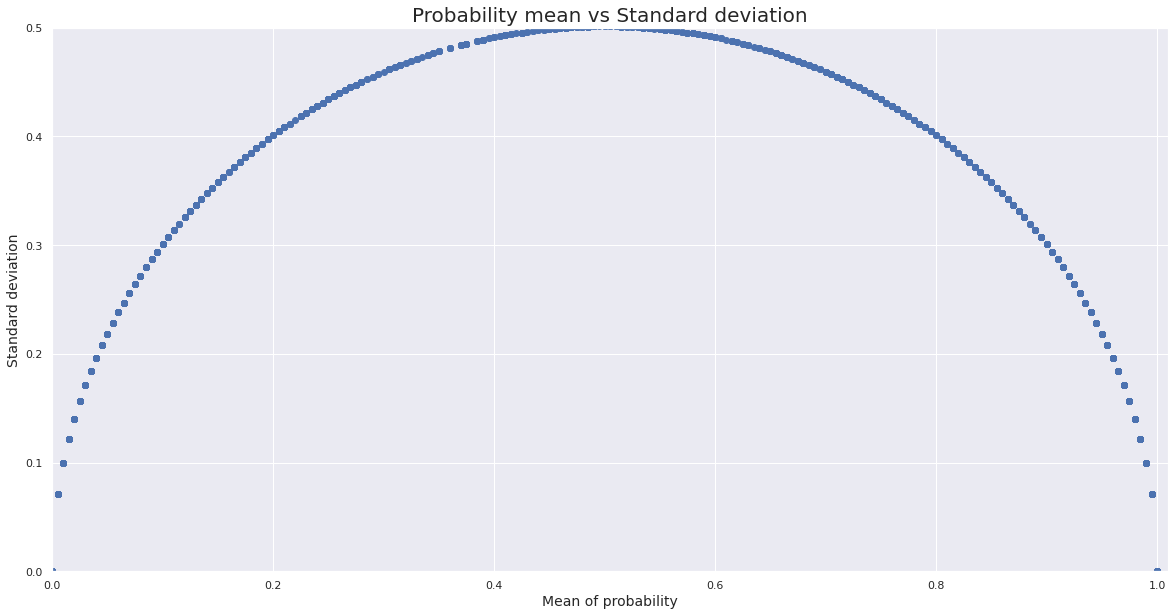

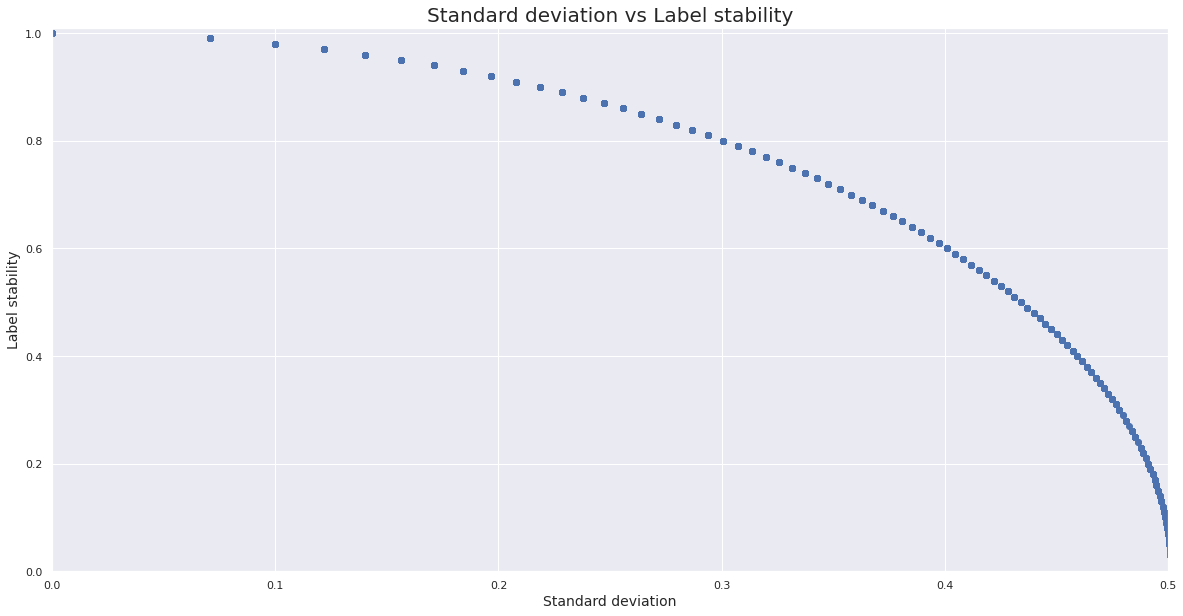

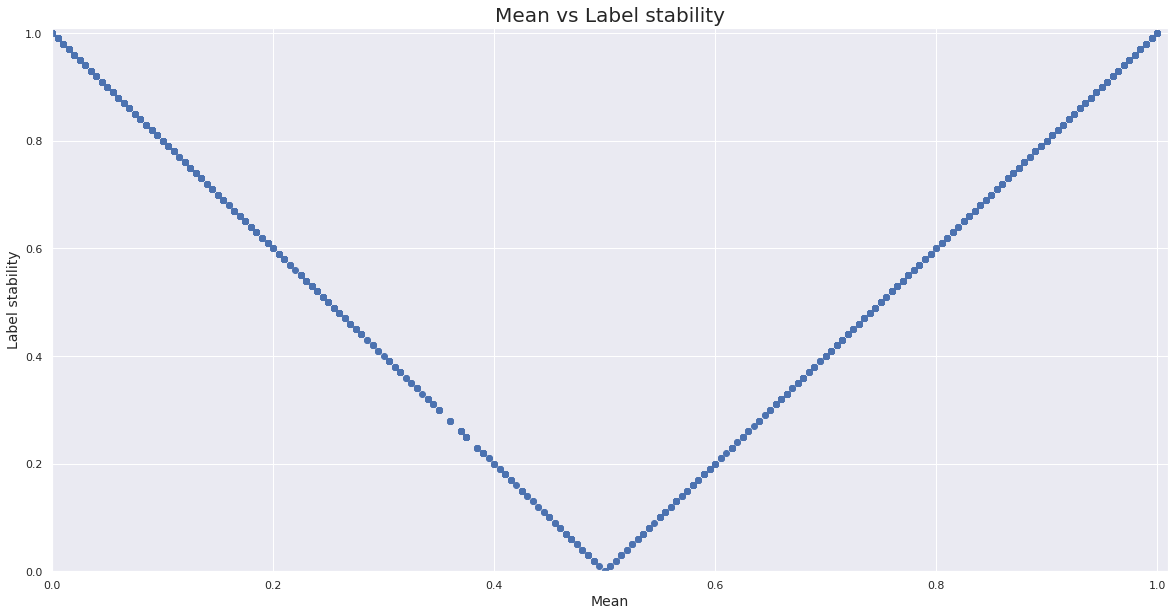

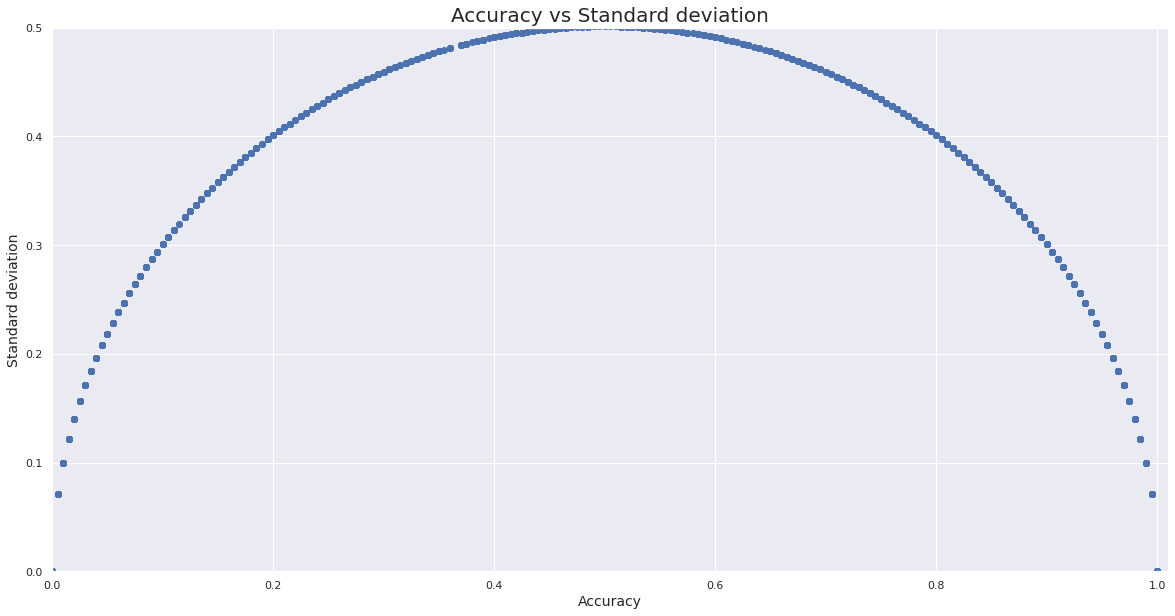

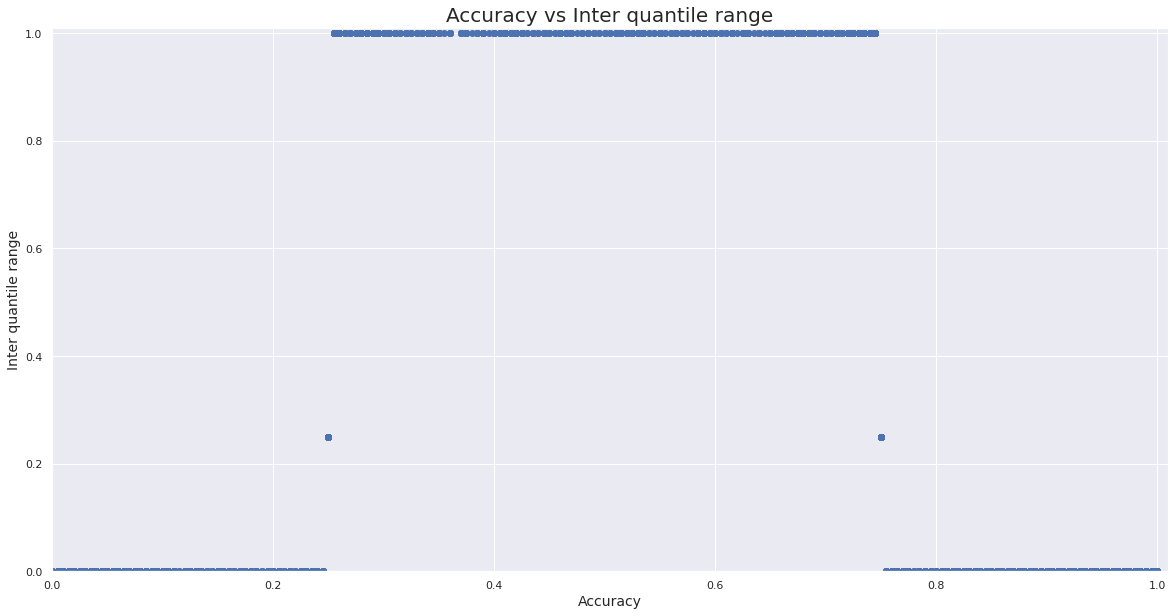



##############################  Fairness metrics  ##############################

#################### Accuracy ####################
            Race     Sex  Race_Sex
adv       0.8115  0.8415    0.8366
disadv    0.8131  0.7853    0.7869
Accuracy -0.0016  0.0562    0.0497

#################### Disparate_Impact ####################
                    Race     Sex  Race_Sex
adv               0.4703  0.4376    0.4759
disadv            0.3978  0.4600    0.4492
Disparate_Impact  0.8458  1.0512    0.9438

#################### Equal_Opportunity ####################
                     Race     Sex  Race_Sex
adv                0.8232  0.8309    0.8352
disadv             0.8045  0.8071    0.8103
Equal_Opportunity  0.0188  0.0238    0.0248

#################### Statistical_Parity_Difference ####################
                                 Race     Sex  Race_Sex
adv                            1.0788  1.0377    1.0208
disadv                         1.1485  1.1517    1.1810
Statistical_Par

In [67]:
stability_fairness_analyzer.measure_metrics(make_plots=True)